## Summary
I really liked this [kernel](https://www.kaggle.com/the1owl/classify-me-again). I think it is very creative and funny to create a model to predict personality from a text and to apply it over kaggle comments. This kernel is a variation of the indicated one where I calculate the accuracy of that model and try other model alternatives. At the end, we apply our best model to know what are the Kaggle community most common personalities, but don't take it too seriously :-)

In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.offline as py
#import plotly.graph_objs as go
#import plotly.tools as tls
from bs4 import BeautifulSoup
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

#py.init_notebook_mode(connected=True)

In [2]:
train = pd.read_csv('../mbti-project/mbti_1.csv')
us = pd.read_csv('../mbti-project/Users.csv')
ps = pd.read_csv('../mbti-project/ForumMessages.csv')
mbti = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}

In [3]:
train.shape

(8675, 2)

We take a look to the classes. It looks like it is a very unbalanced dataset:

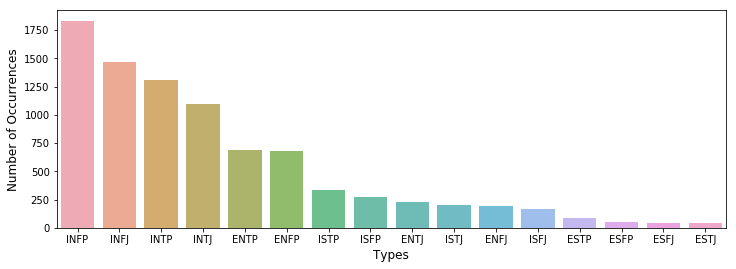

In [4]:
cnt_srs = train['type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Types', fontsize=12)
plt.show()

In [5]:
ps['Message'] = ps['Message'].fillna('')

In [6]:
ps_join = ps.groupby('AuthorUserId')['Message'].agg(lambda col: ' '.join(col)).reset_index()

### ExtraTreesClassifier with SVD
this is the model used in the  [kernel](https://www.kaggle.com/the1owl/classify-me-again). We want to evaluate its performance.

In [7]:
etc = ExtraTreesClassifier(n_estimators = 20, max_depth=4, n_jobs = -1)
tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tsvd = TruncatedSVD(n_components=10)
model = Pipeline([('tfidf1', tfidf), ('tsvd1', tsvd), ('etc', etc)])

In [8]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [9]:
np.random.seed(1)

scoring = {'acc': 'accuracy',
           'neg_log_loss': 'neg_log_loss',
           'f1_micro': 'f1_micro'}

results = cross_validate(model, train['posts'], train['type'], cv=kfolds, 
                          scoring=scoring, n_jobs=-1)

In [10]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results['test_acc']),
                                                          np.std(results['test_acc'])))

print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results['test_f1_micro']),
                                                          np.std(results['test_f1_micro'])))

print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results['test_neg_log_loss']),
                                                          np.std(-1*results['test_neg_log_loss'])))

CV Accuracy: 0.2847 (+/- 0.0151)
CV F1: 0.2847 (+/- 0.0151)
CV Logloss: 2.1542 (+/- 0.0078)


As the dataset is very unbalanced F1 score is a better metric than accuracy

## Alternative models
Let's try if we can find a more accuracy model, although we haven't got a lot of data

In [11]:
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    return text

In [12]:
train['clean_posts'] = train['posts'].apply(cleanText)

### Naive Bayes

In [13]:
np.random.seed(1)

tfidf2 = CountVectorizer(ngram_range=(1, 1), 
                         stop_words='english',
                         lowercase = True, 
                         max_features = 5000)

model_nb = Pipeline([('tfidf1', tfidf2), ('nb', MultinomialNB())])

results_nb = cross_validate(model_nb, train['clean_posts'], train['type'], cv=kfolds, 
                          scoring=scoring, n_jobs=-1)


In [14]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb['test_acc']),
                                                          np.std(results_nb['test_acc'])))

print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb['test_f1_micro']),
                                                          np.std(results_nb['test_f1_micro'])))

print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_nb['test_neg_log_loss']),
                                                          np.std(-1*results_nb['test_neg_log_loss'])))

CV Accuracy: 0.5589 (+/- 0.0097)
CV F1: 0.5589 (+/- 0.0097)
CV Logloss: 6.2748 (+/- 0.2918)


### Logistic Regression

In [15]:
np.random.seed(1)

tfidf2 = CountVectorizer(ngram_range=(1, 1), stop_words='english',
                                                 lowercase = True, max_features = 5000)

model_lr = Pipeline([('tfidf1', tfidf2), ('lr', LogisticRegression(class_weight="balanced", C=0.005))])

results_lr = cross_validate(model_lr, train['clean_posts'], train['type'], cv=kfolds, 
                          scoring=scoring, n_jobs=-1)

In [16]:
print("CV Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_acc']),
                                                          np.std(results_lr['test_acc'])))

print("CV F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_f1_micro']),
                                                          np.std(results_lr['test_f1_micro'])))

print("CV Logloss: {:0.4f} (+/- {:0.4f})".format(np.mean(-1*results_lr['test_neg_log_loss']),
                                                          np.std(-1*results_lr['test_neg_log_loss'])))

CV Accuracy: 0.6659 (+/- 0.0090)
CV F1: 0.6659 (+/- 0.0090)
CV Logloss: 1.2501 (+/- 0.0238)


Is this model overtitting? could we have a better model with more data? Let's see the learning curve:

In [17]:
train_sizes, train_scores, test_scores = \
    learning_curve(model_lr, train['clean_posts'], train['type'], cv=kfolds, n_jobs=-1, 
                   scoring="f1_micro", train_sizes=np.linspace(.1, 1.0, 10), random_state=1)

In [18]:
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):

    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

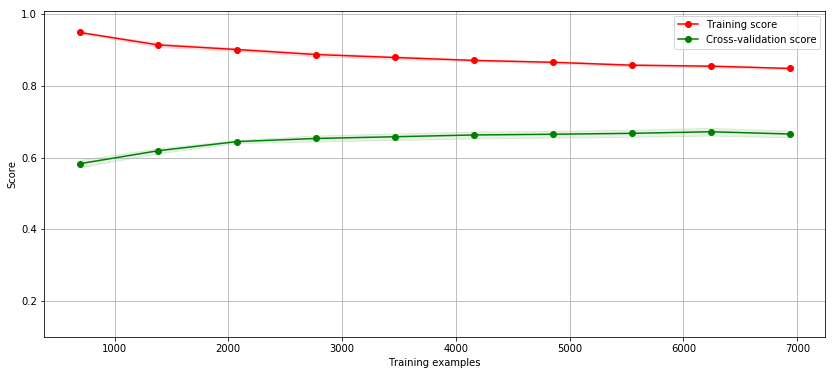

In [19]:
import matplotlib.pyplot as plt

plot_learning_curve(train['posts'], train['type'], train_sizes, 
                    train_scores, test_scores, ylim=(0.1, 1.01), figsize=(14,6))
plt.show()

It looks like that with more data the model gets better and that it is not overfitting. 

## Kaggle users personality
Let's apply our last model to whole kaggle users comments. Let's see what is the most common kaggle user personalities

In [20]:
ps_join['clean_comments'] = ps_join['Message'].apply(cleanText)

In [21]:
model_lr.fit(train['clean_posts'], train['type'])
pred_all = model_lr.predict(ps_join['clean_comments'])

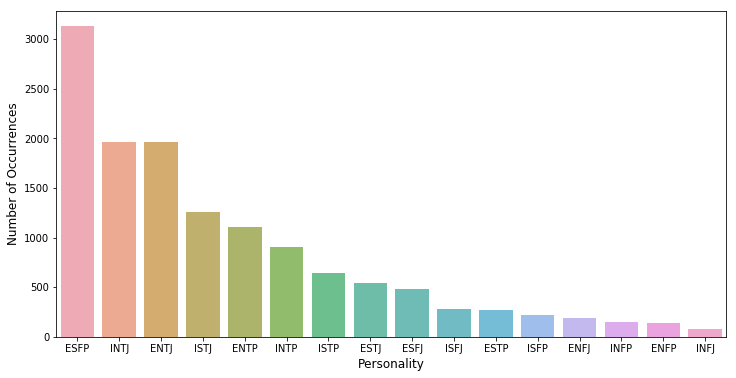

In [22]:
cnt_all = np.unique(pred_all, return_counts=True)

pred_df = pd.DataFrame({'personality': cnt_all[0], 'count': cnt_all[1]},
                      columns=['personality', 'count'], index=None)

pred_df.sort_values('count', ascending=False, inplace=True)

plt.figure(figsize=(12,6))
sns.barplot(pred_df['personality'], pred_df['count'], alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Personality', fontsize=12)
plt.show()

In [23]:
pred_df['percent'] = pred_df['count']/pred_df['count'].sum()

In [24]:
pred_df['description'] = pred_df['personality'].apply(lambda x: ' '.join([mbti[l] for l in list(x)]))

In [25]:
pred_df

,personality,count,percent,description
5,ESFP,3132,0.234783,Extroversion Sensing Feeling Perceiving
10,INTJ,1967,0.147451,Introversion Intuition Thinking Judging
2,ENTJ,1966,0.147376,Extroversion Intuition Thinking Judging
14,ISTJ,1255,0.094078,Introversion Sensing Thinking Judging
3,ENTP,1105,0.082834,Extroversion Intuition Thinking Perceiving
11,INTP,909,0.068141,Introversion Intuition Thinking Perceiving
15,ISTP,642,0.048126,Introversion Sensing Thinking Perceiving
6,ESTJ,546,0.040930,Extroversion Sensing Thinking Judging
4,ESFJ,480,0.035982,Extroversion Sensing Feeling Judging
12,ISFJ,281,0.021064,Introversion Sensing Feeling Judging


In [26]:
labels = pred_df['description']
sizes = pred_df['percent']*100

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Kaggle Personality Distribution'
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

NameError: name 'go' is not defined

## Conclusions
Apparently the most common Kaggle users personality is ESFP (Extroversion Sensing Feeling Perceiving), but we are getting this conclusion based on users comments: it is reasonable to think that users who participate more writting comments are more extrovert. Our sample data don't came from all Kaggle user population, it comes from Kaggle users who write comments so, our conclusion can't be applied to all Kaggle users, only to those who write comments. Farthermore, more accuracy models could be obtained with more data.

